<h1><center>Named Entity Recognition Model using  Clinical BERT </center></h1>
<h4><center>Final Project W266</center></h4>


<h3><center>SUMMARY</center></h3>

In this notebook, we will look at implementing various BERT models to understand the significance of domain specific contexts with respect to fine tuning NER task.

- The various BERT models used in the notebook are listed below.

__BERT:__ 
>"BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", by Devlin/Chang/Lee/Toutanova, Google AI Language)

__BioBERT:__ 
>A pre-trained biomedical language representation model for biomedical text mining by Jinhyuk Lee, Wonjin Yoon, Sungdong Kim, Donghyeon Kim, Sunkyu Kim, Chan Ho So, Jaewoo Kang

__SciBERT:__
>A Pretrained Language Model for Scientific Text by Iz Beltagy, Kyle Lo, Arman Cohan

__ClinicalBert:__
>Modeling Clinical Notes and Predicting Hospital Readmission by Kexin Huang, Jaan Altosaar, Rajesh Ranganath

>Publicly Available Clinical BERT Embeddings by Emily Alsentzer, John R. Murphy, Willie Boag, Wei-Hung Weng, Di Jin, Tristan Naumann, Matthew B. A. McDermott


Models used and their corresponding Corpora used:


__Base Bert Cased -__  

>Wikipedia + BookCorpus

__BioBert Cased with PubMed and PMC - __

>English Wikipedia, General BooksCorpus, General PubMed Abstracts, PMC Full-text articles

__SciBert Cased -__

>1.14M papers from Semantic Scholar (Ammar et al., 2018)

__biobert_pretrain_output_all_notes_150000__

>MIMIC text from all note types on BioBert


__biobert_pretrain_output_disch_100000__

>MIMIC text from all discharge summaries on BioBert


We look at the effect of also fine-tuning BERT layers which are pre-trained with clinical context. 


### 1. Data



In [1]:
!tail -20 'ner_dataset.csv'

",",",",O
M.D,NNP,O
JA25,NNP,O
Attending:,NNP,O
SYDNEY,NNP,O
DUESTERHAUS,NNP,O
",",",",O
M.D,NNP,O
MG85,NNP,O
EQ681/3978,NNP,O
Batch:,NNP,O
37609,CD,O
Index,NNP,O
No,NNP,O
FHOW8875S8,NNP,O
D:,NNP,O
6/10,CD,O
T:,NNP,O
1/22,CD,O
[report_end],NN,O


### II.2. Getting Started<a id="start" />

We start with some imports.

In [2]:
!pip install seqeval[gpu]

In [3]:
import warnings 
warnings.filterwarnings('ignore')
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
#import tensorflow_hub as hub
from time import time
import io
import re
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

from sklearn.model_selection import train_test_split

from tqdm import tqdm, trange


from datetime import datetime
import os
import sys
import zipfile



In [4]:

# Define maximam length of input 'sentences' (post tokenization).
max_word = 40
max_length = 64
bs = 32

In [5]:

import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

Using TensorFlow backend.


### Scientific bert Model 

#### Lets look at the model weights and the vocab file

In [6]:
print(os.listdir("/root"))
print(os.listdir("/root/biobert_pretrain_output_disch_100000"))


['All Models.ipynb', 'scibert_scivocab_cased', 'cuda-repo-ubuntu1604-10-1-local-10.1.168-418.67_1.0-1_amd64.deb', 'ner_tags', 'vocab.txt', 'biobert_pretrain_output_disch_100000', 'biobert_working-pytorch-gpu_v1.ipynb', '.gnupg', 'clibert.bin', 'sentence_boundaries.ipynb', 'all_bert_models-50.ipynb', 'validation_sentences.csv', 'Baseline_model.ipynb', 'biobert.bin', 'scibert-pytorch-gpu.ipynb', 'biobert_pretrain_output_all_notes_150000', 'clinicalbert.bin', 'attention_decoder.py', 'bert_config.json', 'cuda-repo-ubuntu1604-10-1-local-10.1.105-418.39_1.0-1_amd64.deb', 'clinicalbert-pytorch-gpu_notes.ipynb', 'validation_ner.csv', 'pytorch_model.bin', 'sentence_model.h5', '.profile', '.config', 'ner_dataset.csv', 'clinicalbert_working-pytorch-gpu_v1.ipynb', 'data', 'convert_to_pytorch_wt.ipynb', '.keras', '.nv', '.bash_history', 'eos.pyc', 'connengine.ipynb', 'answers', 'parser-bert.ipynb', 'bert_working-pytorch-gpu_v1.ipynb', '.pytorch_pretrained_bert', 'best_model.hdf5', 'config.json', '.

In [7]:
VOCAB = '/root/biobert_pretrain_output_disch_100000/vocab.txt'
MODEL = '/root/biobert_pretrain_output_disch_100000'

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [9]:
torch.cuda.get_device_name(0) 

'Tesla P100-PCIE-16GB'

## III. Data Preprocessing <a id="preprocess" />

### III.1 BERT Tokenizer<a id="tokenizer" />

We first start by defining and exploring the BERT tokenizer:

In [10]:
tokenizer = BertTokenizer.from_pretrained('/root/biobert_pretrain_output_disch_100000', do_lower_case=False)

In [11]:
# Tokenized input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)
print (tokenized_text)


['[CLS]', 'Who', 'was', 'Jim', 'He', '##nson', '?', '[SEP]', 'Jim', 'He', '##nson', 'was', 'a', 'puppet', '##eer', '[SEP]']


In [12]:
tokenizer.tokenize('I\'ll learn to swim in 12342 years.')

['I', "'", 'll', 'learn', 'to', 'swim', 'in', '123', '##42', 'years', '.']

Note how the "I'll" phrase and the number '12342' got split. This already highlights an area one needs to address: splitting of tokens will need to be accounted for in the labeling.

In [13]:
tokenizer.convert_tokens_to_ids(['I', "'", 'll', 'learn', 'to', 'swim', 'in', '123', '##42', 'years', '.'])

[146, 112, 1325, 3858, 1106, 11231, 1107, 13414, 23117, 1201, 119]

In [14]:
tokenizer.convert_ids_to_tokens([20958])

['Faye']

Good. Now we are ready to use it for our text.

### III.2. Extraction<a id="extract"/>


We have seen above how the data set looks. We can now turn to the pre-processing and creating the input for BERT. Specifically, we need to:

1) Tokenize the sentences. Note again that one word can be split into multiple tokens, and we need to insert custom labels when that happens to make sure we don't mess up the alignment. We choose a new 'nerX' label here.

2) Create BERT tokens and add [CLS], [PAD], etc.

3) Convert these tokens into ids, also via the tokenizer. These qill create the sentence_ids.

4) Create the mask ids. Mask out all of the padding tokens.

5) Create the sequence ids. In our case, they are all '0' as we do not compare or even have multiple sentences in one example.

To do this, we first define a helper function:

* This section is from the lecture notebook of W266

In [15]:
def addWord(word, pos, ner):
    """
    Convert a word into a word token and add supplied NER and POS labels. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, pos label, ner label
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc. 
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['posToken'] = [pos] + ['posX'] * (tokenLength - 1)
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    
    
    return addDict


Let's see what it does:

In [16]:
addWord('protest', 'VB', 'O')

{'wordToken': ['protest'],
 'posToken': ['VB'],
 'nerToken': ['O'],
 'tokenLength': 1}

In [17]:
addWord('Iraq', 'NNP', 'B-geo')

{'wordToken': ['Iraq'],
 'posToken': ['NNP'],
 'nerToken': ['B-geo'],
 'tokenLength': 1}

In [18]:
addWord('10000', 'CD', 'O')

{'wordToken': ['1000', '##0'],
 'posToken': ['CD', 'posX'],
 'nerToken': ['O', 'nerX'],
 'tokenLength': 2}

We are now ready to convert the text file into appropriate arrays:

In [19]:
"""
Read the file line by line and construct sentences. A sentence end is marked by the word 'sentence' in the next row.
You need to take care of that. Also, you need to cap sentence length using max_length. Sentences which are shorter than 
max_length need to be padded. Also, we choose to end all sentences with a [SEP] token, padded or not. 
"""

with io.open('ner_dataset.csv', 'r', encoding='utf-8', errors='ignore') as train:
    text = train.readlines()


# lists for sentences, tokens, labels, etc.  
sentenceList = []
word_count = 0
sentenceTokenList = []
posTokenList = []
nerTokenList = []
sentLengthList = []

# lists for BERT input
bertSentenceIDs = []
bertMasks = []
bertSequenceIDs = []

sentence = ''

# always start with [CLS] tokens
sentenceTokens = ['[CLS]']
posTokens = ['[posCLS]']
nerTokens = ['[nerCLS]']

for line in text:
    
    cleanLine = re.sub(r'(?!(([^"]*"){2})*[^"]*$),', '', line)  # deal with '"10,000"' and convert them to '10000' 

    word, pos, ner = cleanLine.split(',')
    
    ner = ner[:-1]   # remove DOS token
    
    # if new sentence starts
    if (word_count >= max_word -1):            
            
        sentenceLength = min(max_length -1, len(sentenceTokens))
        sentLengthList.append(sentenceLength)
        
                    
        # Create space for at least a final '[SEP]' token
        if sentenceLength >= max_length - 1: 
            sentenceTokens = sentenceTokens[:max_length - 2]
            posTokens = posTokens[:max_length - 2]
            nerTokens = nerTokens[:max_length - 2]

        # add a ['SEP'] token and padding
        
        sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))
        
        posTokens += ['[posSEP]'] + ['[posPAD]'] * (max_length - 1 - len(posTokens) )
        nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )
            
        sentenceList.append(sentence)

        sentenceTokenList.append(sentenceTokens)

        bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
        bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
        bertSequenceIDs.append([0] * (max_length))
                             
        posTokenList.append(posTokens)
        nerTokenList.append(nerTokens)
        
        sentence = ''
        sentenceTokens = ['[CLS]']
        posTokens = ['[posCLS]']
        nerTokens = ['[nerCLS]']
        
        sentence += ' ' + word
        word_count = 0
    
    word_count += 1
    addDict = addWord(word, pos, ner)

    sentenceTokens += addDict['wordToken']
    posTokens += addDict['posToken']
    nerTokens += addDict['nerToken']

# The first two list elements need to be removed. 1st line in file is a-typical, and 2nd line does not end a sentence   
sentLengthList = sentLengthList[2:]
sentenceTokenList = sentenceTokenList[2:]
bertSentenceIDs = bertSentenceIDs[2:]
bertMasks = bertMasks[2:]
bertSequenceIDs = bertSequenceIDs[2:]
posTokenList = posTokenList[2:]
nerTokenList = nerTokenList[2:]

What did this do?

In [20]:
print(sentLengthList[4])

47


In [21]:
print(bertSentenceIDs[4])

[101, 2103, 1115, 1123, 2555, 1125, 1151, 2221, 107, 107, 1105, 1175, 1127, 1185, 2091, 8661, 2879, 1895, 27631, 13066, 1224, 1608, 1109, 5884, 1104, 27631, 20702, 1166, 1103, 1736, 1104, 1103, 1480, 107, 107, 1170, 1134, 1553, 1131, 1108, 2752, 1171, 1106, 2001, 10805, 8643, 3875, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [22]:
print(sentenceTokenList[4])

['[CLS]', 'reported', 'that', 'her', 'foot', 'had', 'been', 'blue', '"', '"', 'and', 'there', 'were', 'no', 'Do', '##pp', '##ler', '##able', 'pulses', 'Color', 'later', 'returned', 'The', 'absence', 'of', 'pulses', 'persisted', 'over', 'the', 'course', 'of', 'the', 'night', '"', '"', 'after', 'which', 'point', 'she', 'was', 'referred', 'back', 'to', 'La', '##rg', '##rine', 'Medical', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [23]:
print(nerTokenList[4])

['[nerCLS]', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'O', 'O', 'O', 'O', 'O', 'nerX', 'nerX', 'nerX', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'nerX', 'O', '[nerSEP]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]']


In [24]:
print(bertMasks[4])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


This looks right. Everything past the '[SEP]' token, i.e., the '[nerSEP]' label, is masked out. Also the sequence_ids are correct: there is only one sentence, so all ids should have the same value of zero.

In [25]:
print(bertSequenceIDs[4])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Looks reasonable. 


### III.3. Initial Data Analysis<a id="analysis" />

It is important to understand the dataset prior to doing any modeling or training. First, what are the length of the original sentences.

(array([   5.,    0.,    7.,    0.,    0.,   21.,    0.,    0.,   31.,
           0.,   44.,    0.,    0.,   51.,    0.,    0.,   69.,    0.,
          85.,    0.,    0.,  108.,    0.,    0.,  128.,    0.,  149.,
           0.,    0.,  163.,    0.,    0.,  169.,    0.,    0.,  178.,
           0.,  201.,    0.,    0.,  208.,    0.,    0.,  228.,    0.,
         228.,    0.,    0.,  224.,    0.,    0.,  222.,    0.,  192.,
           0.,    0.,  179.,    0.,    0.,  186.,    0., 4412.]),
 array([40.        , 40.37096774, 40.74193548, 41.11290323, 41.48387097,
        41.85483871, 42.22580645, 42.59677419, 42.96774194, 43.33870968,
        43.70967742, 44.08064516, 44.4516129 , 44.82258065, 45.19354839,
        45.56451613, 45.93548387, 46.30645161, 46.67741935, 47.0483871 ,
        47.41935484, 47.79032258, 48.16129032, 48.53225806, 48.90322581,
        49.27419355, 49.64516129, 50.01612903, 50.38709677, 50.75806452,
        51.12903226, 51.5       , 51.87096774, 52.24193548, 52.6129032

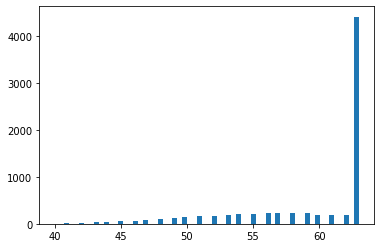

In [26]:
sentenceLengths= [l for l in sentLengthList]

plt.hist(np.array(sentenceLengths), bins=(max_length-2))

In [27]:
numSentences = len(bertSentenceIDs)

nerClasses = pd.DataFrame(np.array(nerTokenList).reshape(-1))
nerClasses.columns = ['tag']
nerClasses.tag = pd.Categorical(nerClasses.tag)
nerClasses['cat'] = nerClasses.tag.cat.codes
nerClasses['sym'] = nerClasses.tag.cat.codes
nerLabels = np.array(nerClasses.cat).reshape(numSentences, -1) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c50107eb8>]],
      dtype=object)

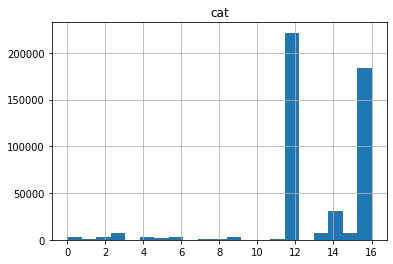

In [28]:
nerClasses[['cat']].hist(bins=21)

Looks like a lot of tables with value 12+

In [29]:
nerDistribution = (nerClasses.groupby(['tag', 'cat']).agg({'sym':'count'}).reset_index()
                   .rename(columns={'sym':'occurences'}))

numNerClasses = nerDistribution.tag.nunique()

nerDistribution

,tag,cat,occurences
0,B-do,0,3520
1,B-du,1,485
2,B-f,2,3171
3,B-m,3,7443
4,B-mo,4,2664
5,B-r,5,1479
6,I-do,6,3146
7,I-du,7,1020
8,I-f,8,1109
9,I-m,9,3321




### III.4. Baseline: Always picking 'Other'<a id="baseline" />

Let's see what a baseline would give for the actual text tokens, if I ALWAYS chose the most common token 'O':

In [30]:
O_occurences = nerDistribution.loc[nerDistribution.tag == 'O','occurences']
All_occurences = nerDistribution[nerDistribution.cat < 13]['occurences'].sum()

O_occurences/All_occurences

12    0.885908
Name: occurences, dtype: float64

So **88.5%** is the baseline

### III.5. Train/Test Split and Final Data Preparation<a id="split" />

In the last step we need to prepare both labels and input for the model, including the train/test split.

In [31]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])



In [32]:
tr_inputs, val_inputs, tr_tags, val_tags, tr_sen, val_sen, tr_ner, val_ner = train_test_split(bertSentenceIDs, 
                                                                                              nerLabels,sentenceTokenList, 
                                                            nerTokenList,random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(bertMasks, bertSentenceIDs,
                                             random_state=2018, test_size=0.1)

In [33]:
print(tr_masks[6])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [34]:
print(tr_inputs[6])

[101, 1132, 15498, 125, 5135, 13335, 8643, 131, 1109, 5351, 1144, 170, 1607, 1104, 17972, 17972, 1335, 1148, 107, 107, 1119, 1108, 1113, 1117, 1313, 13753, 1104, 151, 2101, 3048, 26825, 1134, 1108, 1406, 2338, 4841, 12734, 13064, 3828, 1112, 1218, 1112, 1126, 26825, 7989, 3418, 2279, 1104, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [35]:
tr_tags[6]

array([13, 12, 12, 12, 12, 16, 16, 16, 12, 12, 12, 12, 12, 12,  5,  5, 12,
       12, 12, 16, 12, 12, 12, 12, 12, 12, 12,  3, 16, 16,  9, 12, 12,  0,
        6,  4, 16, 16,  2, 12, 12, 12, 12,  3,  0,  6, 12, 12, 15, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], dtype=int8)

In [36]:
print(sentenceTokenList[6])

['[CLS]', 'on', 'the', '2', 'of', 'September', 'PA', '##ST', 'S', '##UR', '##GI', '##CA', '##L', 'H', '##IS', '##TO', '##R', '##Y', ':', 'Notable', 'for', 'the', 'above', '"', '"', 'as', 'well', 'as', 'de', '##bri', '##de', '##ments', 'of', 'her', 'toe', 'am', '##putation', 'wound', 'site', 'AD', '##MI', '##SS', '##ION', 'ME', '##DI', '##CA', '##TI', '##ON', '##S', ':', 'Cola', '##ce', '100', 'mg', 'b', '.', 'i', '.', 'd', '"', '"', 'insulin', '[SEP]', '[PAD]']


In [37]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags, dtype=torch.long, device=device)
val_tags = torch.tensor(val_tags, dtype=torch.long, device=device)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [38]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [39]:

model = BertForTokenClassification.from_pretrained('/root/biobert_pretrain_output_disch_100000', 
                                                   num_labels=nerDistribution['tag'].count())


In [40]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=7e-6)

In [41]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementw

In [42]:
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [43]:
epochs = 50
max_grad_norm = 1.0

train_loss = []
evaluation_loss = []
f1score = []
for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    train_loss.append(tr_loss/nb_tr_steps)
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    evaluation_loss.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == p_i).idxmax()][0] for p in predictions for p_i in p])
    valid_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][0] for l in true_labels for l_i in l for l_ii in l_i])
    valid_ids = [nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][1] for l in true_labels for l_i in l for l_ii in l_i]
    mask = (np.array(valid_ids) < 13)
    #print(mask)
    pred = np.ma.compressed(np.ma.MaskedArray(pred_tags, mask=~mask))
    valid = np.ma.compressed(np.ma.MaskedArray(valid_tags, mask=~mask))
    #print(pred.tolist())
    print("F1-Score: {}".format(f1_score(pred.tolist(), valid.tolist())))
    f1score.append(f1_score(pred.tolist(), valid.tolist()))
    print("Recall: {}".format(recall_score(pred.tolist(), valid.tolist())))
    

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.6065156456277269
Validation loss: 0.11180051602423191
Validation Accuracy: 0.9568168444511218


Epoch:   2%|▏         | 1/50 [02:38<2:09:45, 158.88s/it]

F1-Score: 0.7033025099075297
Recall: 0.6899948159668222
Train loss: 0.10102702325907363
Validation loss: 0.0713406380576392
Validation Accuracy: 0.9690661308092948


Epoch:   4%|▍         | 2/50 [05:17<2:06:56, 158.67s/it]

F1-Score: 0.8079893475366178
Recall: 0.79884149552396
Train loss: 0.07099105923555755
Validation loss: 0.05854719690978527
Validation Accuracy: 0.9722884740584936


Epoch:   6%|▌         | 3/50 [07:55<2:04:16, 158.65s/it]

F1-Score: 0.8318537859007833
Recall: 0.8069908814589666
Train loss: 0.05682993814419796
Validation loss: 0.05107434932142496
Validation Accuracy: 0.974739270332532


Epoch:   8%|▊         | 4/50 [10:34<2:01:38, 158.66s/it]

F1-Score: 0.8503812779384696
Recall: 0.8305084745762712
Train loss: 0.04854375500920542
Validation loss: 0.047880722830692925
Validation Accuracy: 0.9787550706129808


Epoch:  10%|█         | 5/50 [13:13<1:59:00, 158.68s/it]

F1-Score: 0.857748344370861
Recall: 0.8436685773840542
Train loss: 0.0423513617613728
Validation loss: 0.046780811001857124
Validation Accuracy: 0.9799256936097757


Epoch:  12%|█▏        | 6/50 [15:52<1:56:25, 158.76s/it]

F1-Score: 0.8641188959660299
Recall: 0.8514644351464435
Train loss: 0.0377110873494668
Validation loss: 0.04509274622735878
Validation Accuracy: 0.9814922626201924


Epoch:  14%|█▍        | 7/50 [18:30<1:53:49, 158.82s/it]

F1-Score: 0.865106494872469
Recall: 0.844889573703133
Train loss: 0.032824336242160246
Validation loss: 0.04510757621998588
Validation Accuracy: 0.9814202724358975


Epoch:  16%|█▌        | 8/50 [21:09<1:51:12, 158.87s/it]

F1-Score: 0.8657505285412262
Recall: 0.8495850622406639
Train loss: 0.029551892863560063
Validation loss: 0.04508782868894438
Validation Accuracy: 0.980747320713141


Epoch:  18%|█▊        | 9/50 [23:47<1:48:21, 158.57s/it]

F1-Score: 0.8672659968270755
Recall: 0.8515057113187954
Train loss: 0.026625753940917304
Validation loss: 0.0457497660536319
Validation Accuracy: 0.9809116461338142


Epoch:  20%|██        | 10/50 [26:25<1:45:35, 158.39s/it]

F1-Score: 0.8620326487625065
Recall: 0.8429454170957775
Train loss: 0.023552132470277248
Validation loss: 0.04844613062838713
Validation Accuracy: 0.9803920648036858


Epoch:  22%|██▏       | 11/50 [29:03<1:42:46, 158.11s/it]

F1-Score: 0.8689473684210527
Recall: 0.8492798353909465
Train loss: 0.021452372026369328
Validation loss: 0.04720830350803832
Validation Accuracy: 0.9809194711538461


Epoch:  24%|██▍       | 12/50 [31:41<1:40:06, 158.06s/it]

F1-Score: 0.8701809598741147
Recall: 0.8477261113949923
Train loss: 0.019539412192700174
Validation loss: 0.046832392613093056
Validation Accuracy: 0.980503180088141


Epoch:  26%|██▌       | 13/50 [34:19<1:37:27, 158.05s/it]

F1-Score: 0.873231918868428
Recall: 0.8651507139079851
Train loss: 0.01702951112214776
Validation loss: 0.04875812617441019
Validation Accuracy: 0.980381109775641


Epoch:  28%|██▊       | 14/50 [36:57<1:34:51, 158.09s/it]

F1-Score: 0.8709761842449621
Recall: 0.8468193384223919
Train loss: 0.015490555129415617
Validation loss: 0.05039982652912537
Validation Accuracy: 0.9809507712339743


Epoch:  30%|███       | 15/50 [39:34<1:32:07, 157.92s/it]

F1-Score: 0.8743053717914793
Recall: 0.859074362974519
Train loss: 0.014277176835499174
Validation loss: 0.05310419163045784
Validation Accuracy: 0.9806455954527243


Epoch:  32%|███▏      | 16/50 [42:12<1:29:23, 157.75s/it]

F1-Score: 0.8689762959103934
Recall: 0.8411497730711044
Train loss: 0.013359566523706743
Validation loss: 0.051852429285645485
Validation Accuracy: 0.9811542217548076


Epoch:  34%|███▍      | 17/50 [44:49<1:26:42, 157.65s/it]

F1-Score: 0.8677469942498693
Recall: 0.8426395939086294
Train loss: 0.01202116033472827
Validation loss: 0.0547023283628126
Validation Accuracy: 0.9818662985777243


Epoch:  36%|███▌      | 18/50 [47:27<1:24:02, 157.57s/it]

F1-Score: 0.8783320137239377
Recall: 0.8608380755302638
Train loss: 0.011117282145881752
Validation loss: 0.05547616661836704
Validation Accuracy: 0.9815705128205128


Epoch:  38%|███▊      | 19/50 [50:04<1:21:18, 157.38s/it]

F1-Score: 0.8736292428198433
Recall: 0.8475177304964538
Train loss: 0.009988141919252291
Validation loss: 0.0588018661364913
Validation Accuracy: 0.9822434645432692


Epoch:  40%|████      | 20/50 [52:41<1:18:38, 157.28s/it]

F1-Score: 0.882149507847832
Recall: 0.8712559117183395
Train loss: 0.008963387782831116
Validation loss: 0.05927949600542585
Validation Accuracy: 0.9830259665464743


Epoch:  42%|████▏     | 21/50 [55:19<1:16:13, 157.69s/it]

F1-Score: 0.8745709004489042
Recall: 0.8575867426204039
Train loss: 0.008218237648550333
Validation loss: 0.05938801929975549
Validation Accuracy: 0.9830463115985576


Epoch:  44%|████▍     | 22/50 [57:58<1:13:45, 158.06s/it]

F1-Score: 0.8787718369507677
Recall: 0.8636836628511967
Train loss: 0.007563564945972344
Validation loss: 0.06422962620854378
Validation Accuracy: 0.9832012469951924


Epoch:  46%|████▌     | 23/50 [1:00:36<1:11:09, 158.14s/it]

F1-Score: 0.8583120204603581
Recall: 0.8169425511197663
Train loss: 0.007481826707650135
Validation loss: 0.060147714180250965
Validation Accuracy: 0.9822325095152243


Epoch:  48%|████▊     | 24/50 [1:03:14<1:08:24, 157.88s/it]

F1-Score: 0.8661953390940037
Recall: 0.8425878757004585
Train loss: 0.006815139272954245
Validation loss: 0.06316868060578902
Validation Accuracy: 0.9828522511017628


Epoch:  50%|█████     | 25/50 [1:05:51<1:05:42, 157.70s/it]

F1-Score: 0.8674824264514449
Recall: 0.839294710327456
Train loss: 0.006010877430026301
Validation loss: 0.0633628903888166
Validation Accuracy: 0.982700445713141


Epoch:  52%|█████▏    | 26/50 [1:08:28<1:03:00, 157.52s/it]

F1-Score: 0.8737812911725955
Recall: 0.8550799381124291
Train loss: 0.005590603961907239
Validation loss: 0.06566476565785706
Validation Accuracy: 0.9824766501402243


Epoch:  54%|█████▍    | 27/50 [1:11:06<1:00:23, 157.54s/it]

F1-Score: 0.8696339215169869
Recall: 0.85059247810407
Train loss: 0.00530130102633503
Validation loss: 0.0672726290455709
Validation Accuracy: 0.981845953525641


Epoch:  56%|█████▌    | 28/50 [1:13:43<57:44, 157.49s/it]  

F1-Score: 0.8674004192872117
Recall: 0.8443877551020408
Train loss: 0.004700552559318683
Validation loss: 0.06776723459673424
Validation Accuracy: 0.9823749248798076


Epoch:  58%|█████▊    | 29/50 [1:16:20<55:06, 157.44s/it]

F1-Score: 0.8729368614094838
Recall: 0.8495665476797553
Train loss: 0.00465047990357596
Validation loss: 0.06991555518470705
Validation Accuracy: 0.9821104392027243


Epoch:  60%|██████    | 30/50 [1:18:59<52:36, 157.85s/it]

F1-Score: 0.870712401055409
Recall: 0.8531540847983454
Train loss: 0.004286651985230966
Validation loss: 0.0732703961742421
Validation Accuracy: 0.9820494040464743


Epoch:  62%|██████▏   | 31/50 [1:21:38<50:02, 158.01s/it]

F1-Score: 0.8683867604899661
Recall: 0.8409893992932862
Train loss: 0.004290022216108296
Validation loss: 0.07083937463661034
Validation Accuracy: 0.9817254482171475


Epoch:  64%|██████▍   | 32/50 [1:24:17<47:29, 158.29s/it]

F1-Score: 0.8708661417322835
Recall: 0.8490276356192425
Train loss: 0.003937860651099525
Validation loss: 0.07485839646930496
Validation Accuracy: 0.9814093174078525


Epoch:  66%|██████▌   | 33/50 [1:26:56<44:55, 158.57s/it]

F1-Score: 0.8615463652709991
Recall: 0.8232695139911634
Train loss: 0.003570415703325987
Validation loss: 0.07269719972585638
Validation Accuracy: 0.9825376852964743


Epoch:  68%|██████▊   | 34/50 [1:29:34<42:14, 158.44s/it]

F1-Score: 0.8650338718082334
Recall: 0.8375378405650857
Train loss: 0.0035258664349419556
Validation loss: 0.07334908074699342
Validation Accuracy: 0.9821714743589743


Epoch:  70%|███████   | 35/50 [1:32:13<39:38, 158.54s/it]

F1-Score: 0.872870249017038
Recall: 0.8499234303215927
Train loss: 0.0031358355014050885
Validation loss: 0.07753302343189716
Validation Accuracy: 0.9812559470152243


Epoch:  72%|███████▏  | 36/50 [1:34:52<37:00, 158.64s/it]

F1-Score: 0.8625518672199171
Recall: 0.8315
Train loss: 0.0029958581009971296
Validation loss: 0.07594458168993394
Validation Accuracy: 0.9826785356570512


Epoch:  74%|███████▍  | 37/50 [1:37:30<34:22, 158.62s/it]

F1-Score: 0.8730325288562434
Recall: 0.8507157464212679
Train loss: 0.0032480185095858606
Validation loss: 0.07633086177520454
Validation Accuracy: 0.9823843149038461


Epoch:  76%|███████▌  | 38/50 [1:40:08<31:42, 158.53s/it]

F1-Score: 0.877341070957531
Recall: 0.8594315245478036
Train loss: 0.0026070820418698493
Validation loss: 0.07584241513783734
Validation Accuracy: 0.9835345928485576


Epoch:  78%|███████▊  | 39/50 [1:42:46<29:01, 158.30s/it]

F1-Score: 0.868994486741927
Recall: 0.8474142345110087
Train loss: 0.002544470572920287
Validation loss: 0.08072701818309724
Validation Accuracy: 0.9832090720152243


Epoch:  80%|████████  | 40/50 [1:45:24<26:22, 158.25s/it]

F1-Score: 0.8758238861059846
Recall: 0.8575116159008777
Train loss: 0.002301920767637936
Validation loss: 0.0789772750188907
Validation Accuracy: 0.9823749248798076


Epoch:  82%|████████▏ | 41/50 [1:48:02<23:43, 158.20s/it]

F1-Score: 0.8672659968270755
Recall: 0.8515057113187954
Train loss: 0.002153098924743162
Validation loss: 0.08239562188585599
Validation Accuracy: 0.981723883213141


Epoch:  84%|████████▍ | 42/50 [1:50:41<21:05, 158.22s/it]

F1-Score: 0.8744088281660536
Recall: 0.8533333333333334
Train loss: 0.0022403867914583047
Validation loss: 0.08083219298472007
Validation Accuracy: 0.9834422576121794


Epoch:  86%|████████▌ | 43/50 [1:53:18<18:26, 158.08s/it]

F1-Score: 0.8798718633208756
Recall: 0.8719576719576719
Train loss: 0.0019994461969971783
Validation loss: 0.08085960894823074
Validation Accuracy: 0.9838804587339743


Epoch:  88%|████████▊ | 44/50 [1:55:56<15:47, 157.99s/it]

F1-Score: 0.8729194187582563
Recall: 0.8564022809745983
Train loss: 0.00214543335421962
Validation loss: 0.07817654373745124
Validation Accuracy: 0.9838100335536858


Epoch:  90%|█████████ | 45/50 [1:58:34<13:09, 157.86s/it]

F1-Score: 0.8718492968957283
Recall: 0.8588604286461056
Train loss: 0.0018481832219428996
Validation loss: 0.08069920330308378
Validation Accuracy: 0.984470465244391


Epoch:  92%|█████████▏| 46/50 [2:01:12<10:31, 158.00s/it]

F1-Score: 0.8756245069681831
Recall: 0.8551617873651772
Train loss: 0.001818753399963985
Validation loss: 0.08267032463724415
Validation Accuracy: 0.9836879632411858


Epoch:  94%|█████████▍| 47/50 [2:03:50<07:53, 157.97s/it]

F1-Score: 0.873394495412844
Recall: 0.8504338948443083
Train loss: 0.0017962134169426777
Validation loss: 0.0816871748926739
Validation Accuracy: 0.9841152093349358


Epoch:  96%|█████████▌| 48/50 [2:06:29<05:16, 158.13s/it]

F1-Score: 0.8738428987040464
Recall: 0.8581818181818182
Train loss: 0.0015380799793665875
Validation loss: 0.08286839793436229
Validation Accuracy: 0.9831480368589743


Epoch:  98%|█████████▊| 49/50 [2:09:06<02:37, 157.87s/it]

F1-Score: 0.8807682048546279
Recall: 0.8721605916534602
Train loss: 0.0013778363394159803
Validation loss: 0.08441640669479966
Validation Accuracy: 0.982090094150641


Epoch: 100%|██████████| 50/50 [2:11:44<00:00, 158.01s/it]

F1-Score: 0.8732767762460233
Recall: 0.8596033402922756


In [44]:
!pip install scipy

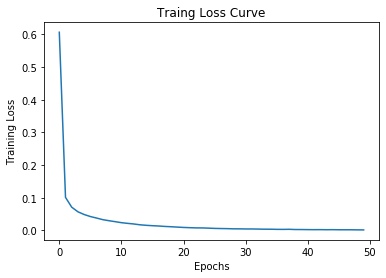

In [45]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Traing Loss Curve")
plt.show()

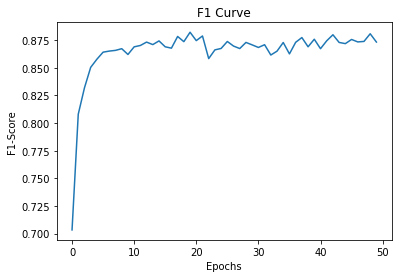

In [46]:
import matplotlib.pyplot as plt

plt.plot(f1score)
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.title("F1 Curve")
plt.show()

In [47]:
model1 = BertForTokenClassification.from_pretrained('/root/biobert_pretrain_output_disch_100000', num_labels=nerDistribution['tag'].count())
#model = BertForTokenClassification.from_pretrained("scibert-basevocab-cased", num_labels=len(tag2idx))

In [48]:
import re

regexp = re.compile(r'layer\.[0-11]\.')
for name, param in model1.named_parameters():                
    #print (name,regexp.search(name) )
    if regexp.search(name):
        #print(name)
        param.requires_grad = False

In [49]:
model1.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementw

In [50]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=2e-1)

In [51]:
epochs = 15
max_grad_norm = 1.0

for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model1.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model1(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model1.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model1.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    # VALIDATION on validation set
    model1.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model1(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model1(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == p_i).idxmax()][0] for p in predictions for p_i in p])
    valid_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][0] for l in true_labels for l_i in l for l_ii in l_i])
    valid_ids = [nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][1] for l in true_labels for l_i in l for l_ii in l_i]
    mask = (np.array(valid_ids) < 13)
    #print(mask)
    pred = np.ma.compressed(np.ma.MaskedArray(pred_tags, mask=~mask))
    valid = np.ma.compressed(np.ma.MaskedArray(valid_tags, mask=~mask))
    #print(pred.tolist())
    print("F1-Score: {}".format(f1_score(pred.tolist(), valid.tolist())))
    print("Recall: {}".format(recall_score(pred.tolist(), valid.tolist())))
    

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 2.836097852878661
Validation loss: 2.8212015529473624
Validation Accuracy: 0.055002065805288464


Epoch:   7%|▋         | 1/15 [02:36<36:28, 156.35s/it]

F1-Score: 0.014627138566018022
Recall: 0.007956429078853895
Train loss: 2.836154917405115
Validation loss: 2.8212015529473624
Validation Accuracy: 0.055002065805288464


Epoch:  13%|█▎        | 2/15 [05:12<33:52, 156.34s/it]

F1-Score: 0.014627138566018022
Recall: 0.007956429078853895
Train loss: 2.836018539717977
Validation loss: 2.8212015529473624
Validation Accuracy: 0.055002065805288464


Epoch:  20%|██        | 3/15 [07:48<31:14, 156.23s/it]

F1-Score: 0.014627138566018022
Recall: 0.007956429078853895
Train loss: 2.8364907395783194
Validation loss: 2.8212015529473624
Validation Accuracy: 0.055002065805288464


Epoch:  27%|██▋       | 4/15 [10:24<28:38, 156.20s/it]

F1-Score: 0.014627138566018022
Recall: 0.007956429078853895
Train loss: 2.836280938008385
Validation loss: 2.8212015529473624
Validation Accuracy: 0.055002065805288464


Epoch:  33%|███▎      | 5/15 [13:00<26:01, 156.15s/it]

F1-Score: 0.014627138566018022
Recall: 0.007956429078853895
Train loss: 2.8362187039795645
Validation loss: 2.8212015529473624
Validation Accuracy: 0.055002065805288464


Epoch:  40%|████      | 6/15 [15:37<23:26, 156.25s/it]

F1-Score: 0.014627138566018022
Recall: 0.007956429078853895
Train loss: 2.8362153005825963
Validation loss: 2.8212015529473624
Validation Accuracy: 0.055002065805288464


Epoch:  47%|████▋     | 7/15 [18:14<20:51, 156.49s/it]

F1-Score: 0.014627138566018022
Recall: 0.007956429078853895
Train loss: 2.835890106680269
Validation loss: 2.8212015529473624
Validation Accuracy: 0.055002065805288464


Epoch:  53%|█████▎    | 8/15 [20:51<18:16, 156.64s/it]

F1-Score: 0.014627138566018022
Recall: 0.007956429078853895
Train loss: 2.836035940884414
Validation loss: 2.8212015529473624
Validation Accuracy: 0.055002065805288464


Epoch:  60%|██████    | 9/15 [23:28<15:40, 156.74s/it]

F1-Score: 0.014627138566018022
Recall: 0.007956429078853895
Train loss: 2.8364099744371893
Validation loss: 2.8212015529473624
Validation Accuracy: 0.055002065805288464


Epoch:  67%|██████▋   | 10/15 [26:04<13:02, 156.43s/it]

F1-Score: 0.014627138566018022
Recall: 0.007956429078853895
Train loss: 2.8365872674643713
Validation loss: 2.8212015529473624
Validation Accuracy: 0.055002065805288464


Epoch:  73%|███████▎  | 11/15 [28:40<10:25, 156.36s/it]

F1-Score: 0.014627138566018022
Recall: 0.007956429078853895
Train loss: 2.8360407894821527
Validation loss: 2.8212015529473624
Validation Accuracy: 0.055002065805288464


Epoch:  80%|████████  | 12/15 [31:17<07:49, 156.50s/it]

F1-Score: 0.014627138566018022
Recall: 0.007956429078853895
Train loss: 2.835803286159208
Validation loss: 2.8212015529473624
Validation Accuracy: 0.055002065805288464


Epoch:  87%|████████▋ | 13/15 [33:53<05:13, 156.58s/it]

F1-Score: 0.014627138566018022
Recall: 0.007956429078853895
Train loss: 2.8358049098914266
Validation loss: 2.8212015529473624
Validation Accuracy: 0.055002065805288464


Epoch:  93%|█████████▎| 14/15 [36:30<02:36, 156.74s/it]

F1-Score: 0.014627138566018022
Recall: 0.007956429078853895
Train loss: 2.836046408702977
Validation loss: 2.8212015529473624
Validation Accuracy: 0.055002065805288464


Epoch: 100%|██████████| 15/15 [39:07<00:00, 156.56s/it]

F1-Score: 0.014627138566018022
Recall: 0.007956429078853895
